In [ ]:
!pip install gdown wandb

In [ ]:
import wandb
wandb.login()

In [3]:
import gdown
import os

DATA_PATH = '/kaggle/input/crawled-cakes'

def download(url, output, *args, **kwargs):
  if os.path.exists(output):
    print('the file already exist!')
    return
  gdown.download(url, output, *args, **kwargs)


url = 'https://drive.google.com/file/d/1ezlW2jo8VVj8AD5mirdRCXFEnIf_zflD/view'
output = 'generated_cakes.zip'

# download(url, output, quiet=False, fuzzy=True)

In [4]:
url2 = 'https://drive.google.com/file/d/16yNwt9Lc9ZT2qYdXY6b0DBW66l2bTcg6/view?usp=share_link'
output = 'crawled_cakes.zip'
# download(url, output, quiet=False, fuzzy=True)

# Discrimivative model
## Setup


In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Discriminative network

In [7]:
# Input shape: [N, 3, 32, 32]
class DiscriminativeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_args = {
            'kernel_size': (4, 4),
            'stride': 2,
            'padding': 1,
        }

        self.model = nn.Sequential(
            # 1.
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                **self.conv_args,
            ),
            # [N, 32, 16, 16]
            nn.BatchNorm2d(32),
            # L2 regularization
            nn.LeakyReLU(0.2),

            # 2.
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                **self.conv_args,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 3.
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                **self.conv_args,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 4 * 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

discriminative_model = DiscriminativeNetwork().to(device)

## Generative network

In [8]:
# Input shape: [N, 1, 64]
class GenerativeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_args = {
            'kernel_size': (4, 4),
            'stride': 2,
            'padding': 1,
        }

        self.model = nn.Sequential(
            nn.Linear(64, 64 * 4 * 4),
            # [N, 1, 64 * 4 * 4]
            nn.Unflatten(
                dim=1,
                unflattened_size=(64, 4, 4),
            ),
            # [N, 64, 4, 4]
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=64,
                **self.conv_args,
            ),
            nn.LeakyReLU(0.2),
            # [N, 64, 8, 8]
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=128,
                **self.conv_args,
            ),
            nn.LeakyReLU(0.2),

            # [N, 128, 16, 16]

            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=256,
                **self.conv_args,
            ),
            nn.LeakyReLU(0.2),

            # [N, 256, 32, 32]
            nn.Conv2d(
                in_channels=256,
                out_channels=3,
                kernel_size=(5, 5),
                padding='same',

            ),
            nn.LeakyReLU(0.2),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)


generative_model = GenerativeNetwork().to(device)
input_tensor = torch.randn(4, 64).to(device)

def print_sizes(model, input_tensor):
    output = input_tensor
    print(output.shape, 'initial')
    for m in model.children():
        output = m(output)
        print(output.shape, '\t', m)

# print_sizes(generative_model.model, input_tensor)

In [9]:
discriminative_model = DiscriminativeNetwork().to(device)

In [10]:
generative_model = GenerativeNetwork().to(device)

## Model before training

In [11]:
random_input = torch.randn(4, 64).to(device)
random_images = generative_model(random_input)

print(random_images[0].shape)
print(random_images[0].max(), random_images[0].min())

print(discriminative_model(random_images))

torch.Size([3, 32, 32])
tensor(0.0119, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0006, device='cuda:0', grad_fn=<MinBackward1>)
tensor([[0.7467],
        [0.4128],
        [0.4482],
        [0.5390]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


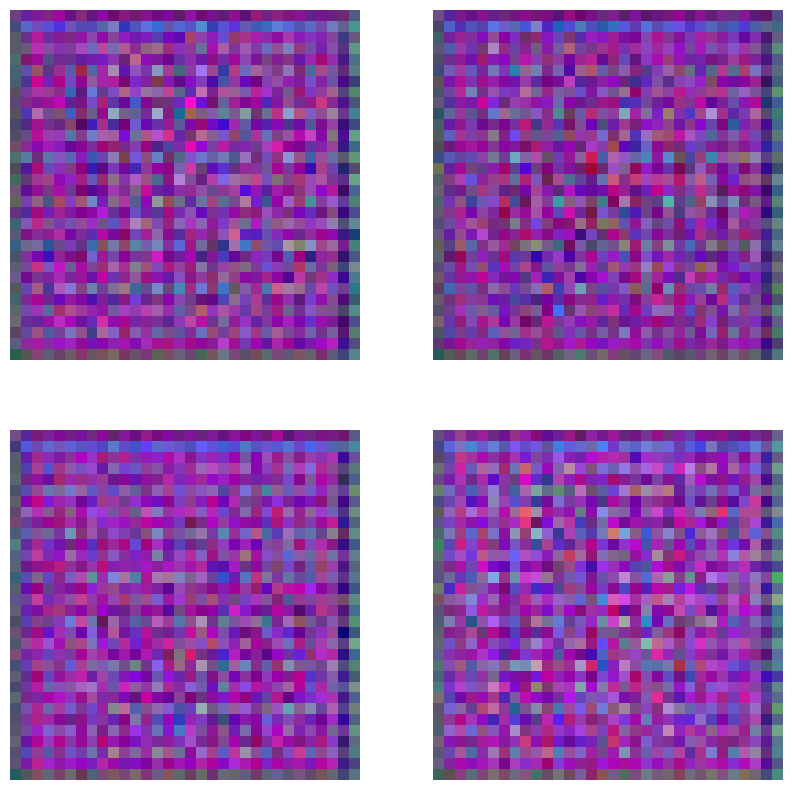

In [12]:
def display_images(images):
    # Assuming the tensor is of size [channels, 32, 32]:

    # Make a grid to display multiple images at the same time in a grid
    n_rows = 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        # Only draw the images if there is one at that position
        if i < len(images):
            # We don't want to crowd the image
            ax.axis('off')
            images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
            ax.imshow(images[i].permute(1, 2, 0).cpu())
            print(images[i].cpu().min(), images[i].cpu().max())
    plt.show()

display_images(random_images.detach())

In [13]:
if not os.path.isdir(DATA_PATH):
  !unzip crawled_cakes.zip
  !mv crawled_cakes/* input/crawled_cakes
else:
  print('already loaded')

already loaded


## Prepare training data

Dataset ImageFolder
    Number of datapoints: 975
    Root location: /kaggle/input/crawled-cakes
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


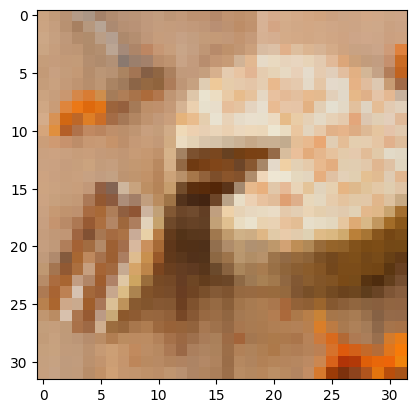

In [14]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

training_data = datasets.ImageFolder(
    root=DATA_PATH,
    transform=transform
  )

print(training_data)

plt.imshow(training_data[0][0].permute(1, 2, 0))
plt.show()

# Warmup

In [15]:
# Input shape: [N, 4]
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.Linear(16, 4),
        )

    def forward(self, x):
        return self.layers(x)

    def print_weights(self):
      def get_layer(layer):
        return f'L{layer}: {torch.mean(self.layers[layer].weight).item():.2f}'
      print(get_layer(0), '\t', get_layer(1))

L0: -0.07 	 L1: -0.03
Loss: 41.74541091918945
Loss: 38.810546875
Loss: 32.94664001464844
Loss: 26.528345108032227
Loss: 19.76386260986328
Loss: 12.398368835449219
Loss: 5.584953308105469
Loss: 1.6644744873046875
Loss: 1.87542724609375
Loss: 1.1041717529296875
L0: -2.82 	 L1: -0.03


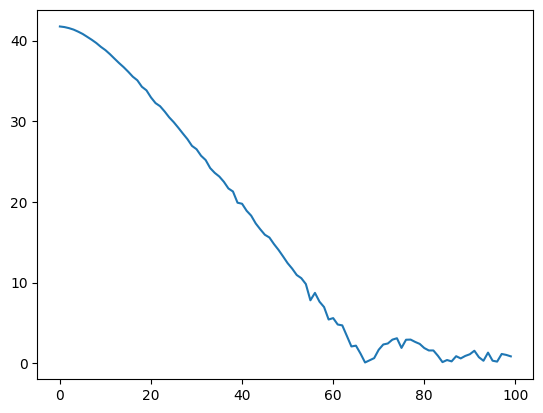

In [16]:
torch.manual_seed(3)

small_model = SmallModel().to(device)
optimizer = torch.optim.SGD(small_model.layers[0].parameters(), lr=0.3, momentum=0.9)

small_model.print_weights()

y = []
for i in range(100):
  optimizer.zero_grad()

  example_data = torch.rand(256, 4).to(device)

  outputs = small_model(example_data)
  loss = (torch.mean(outputs) - 42).abs()
  loss.backward()

  optimizer.step()
  y.append(loss.item())

  if i % 10 == 0:
    print(f'Loss: {loss}')

small_model.print_weights()

plt.plot(y)
plt.show()

# Training

In [ ]:
BATCH_SIZE = 16
PRINT_EVERY_EPOCH = 50
EPOCHS = 2000
LR_DIS = 0.00001
LR_GEN = 0.00001
TEST_SIZE = 25
MODEL_SAVE_EVERY_EPOCH = 250

# prepare valid values
test_random_vector = torch.randn(TEST_SIZE, 64).to(device)
test_labels = torch.cat((torch.ones(TEST_SIZE), torch.zeros(TEST_SIZE))).to(device)

test_dataloader = DataLoader(training_data, batch_size=TEST_SIZE)
test_images, _ = next(iter(test_dataloader))
test_images = test_images.to(device)

# prepare models
discriminative_model = DiscriminativeNetwork().to(device)
generative_model = GenerativeNetwork().to(device)

dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
criterion = nn.BCELoss()

optimizer1 = torch.optim.Adam(discriminative_model.parameters(), lr=LR_DIS)
optimizer2 = torch.optim.Adam(generative_model.parameters(), lr=LR_GEN)

images = []

# prepare logs
run = wandb.init(
    # Set the project where this run will be logged
    project="gen-images",
    # Track hyperparameters and run metadata
    config={
        "learning_rate_discriminative": LR_DIS,
        "learning_rate_generative": LR_GEN,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "test_size": TEST_SIZE
    })

print('starting training...')

for epoch in tqdm(range(EPOCHS)):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss2 = 0.0
    
    for data, _ in dataloader:
        data = data.to(device)
        # zero the parameter gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        discriminative_model.train()
        generative_model.eval()

        sample_size = len(data)

        # generate fake images
        random_input = torch.randn(sample_size, 64).to(device)

        fake_images = generative_model(random_input)

        # create batch
        train_data = torch.cat((data, fake_images))
        labels = torch.cat((torch.ones(sample_size), torch.zeros(sample_size)))

        # add noise to labels
        labels[:sample_size] -= torch.rand(sample_size) / 10

        labels = torch.unsqueeze(labels, 1).to(device)

        # forward + backward + optimize
        outputs = discriminative_model(train_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        discriminative_model.eval()
        generative_model.train()
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()

        # generator
        random_input = torch.randn(sample_size, 64).to(device)
        generated_images = generative_model(random_input)
        labels = torch.ones(sample_size).unsqueeze(1).to(device)

        result = discriminative_model(generated_images)
        loss2 = criterion(result, labels)

        loss2.backward()
        optimizer2.step()
        
        # print statistics
        running_loss += loss.item()
        running_loss2 += loss2.item()
        
    # validate
    discriminative_model.eval()
    generative_model.eval()

    valid_generated_images = generative_model(test_random_vector)
    valid_data = torch.cat((test_images, valid_generated_images))
    valid_scores = discriminative_model(valid_data).squeeze()
    valid_prediction = (valid_scores > 0.5).long()
    
    avg_real_scores = valid_scores[:TEST_SIZE].mean()
    avg_fake_scores = valid_scores[TEST_SIZE:].mean()
    
    total = len(valid_data)
    correct = (valid_prediction == test_labels).sum().item()
    
    accuracy = correct / total
    images_to_send = [wandb.Image((im - im.min()) / (im.max() - im.min())) for im in valid_generated_images[:5]]
    
    img = valid_generated_images[0]
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0).cpu().detach().numpy() 
    images.append(img)

    wandb.log({
        "loss_discriminative": loss,
        "loss_generative": loss2,
        "examples": images_to_send,
        "epoch": epoch, 
        "accuracy": accuracy,
        "avg_real_scores": avg_real_scores,
        "avg_fake_scores": avg_fake_scores,
    })

    if epoch % PRINT_EVERY_EPOCH == 0:
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_EVERY_EPOCH:.3f} \tloss2: {running_loss2 / PRINT_EVERY_EPOCH:.3f} \taccuracy {accuracy:.2f}')
        
    if epoch % MODEL_SAVE_EVERY_EPOCH == 0:
        print('saving model...')
        state = {
            'epoch': epoch + 1,
            'state_dict_gen': generative_model.state_dict(),
            'state_dict_dis': discriminative_model.state_dict(),
            'optimizer_gen': optimizer2.state_dict(), 
            'optimizer_dis': optimizer1.state_dict()
        }
        torch.save(generative_model.state_dict(), f'models_{epoch}.pt')

print('Finished Training!')
run.finish()

starting training...


  0%|          | 0/2000 [00:00<?, ?it/s]

[1,   100] loss: 0.579 	loss2: 1.263 	accuracy 1.00
saving model...


## Results

In [ ]:
valid_generated_images = generative_model(test_random_vector)
display_images(valid_generated_images.detach())

In [ ]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.imshow(images[i])

ani = animation.FuncAnimation(fig, animate, frames=len(images), repeat=True)
ani.save('animation.mp4', fps=60)
plt.show()